In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import os.path
from phacsl.utils.collections.phacollections import SingletonMetaClass
import pyrheautils
import random
from collections import deque, defaultdict
from policybase import TransferDestinationPolicy as BaseTransferDestinationPolicy
from facilitybase import CareTier, tierToQueueMap
from map_transfer_matrix import parseFacilityData
import schemautils


In [2]:

_validator = None
_constants_values = '$(MODELDIR)/constants/transferbydrawwithreplacement_constants.yaml'
_constants_schema = 'transferbydrawwithreplacement_constants_schema.yaml'
_constants = None


schemautils.setSchemaBasePath('/home/welling/git/pyRHEA_github/src/schemata')
    
pyrheautils.PATH_STRING_MAP['MODELDIR'] = '/home/welling/git/pyRHEA_github/models/ChicagoLand'
_constants = pyrheautils.importConstants(_constants_values,
                                         _constants_schema)
_constants['transferFilePaths']=['$(MODELDIR)/hosp_indirect_transfer_counts.yaml',
                                 '$(MODELDIR)/nh_readmit_transfer_counts.yaml'
                                ]

print _constants
nmDict = CareTier.names
#tierFacSets = {tier: set(self.getTierAddrMap(tier).keys()) for tier in nmDict.keys()}
tbl = {}
pairsSeen = set()
for transferMatrixFilePath in _constants['transferFilePaths']:
    print 'Importing the weight data file %s' % transferMatrixFilePath
    rawTbl = pyrheautils.importConstants(transferMatrixFilePath,
                                         _constants['transferFileSchema'])
    for srcName, rec in rawTbl.items():
        if srcName not in tbl:
            tbl[srcName] = {}
        for destName, ct in rec.items():
            if (srcName, destName) in pairsSeen:
                raise RuntimeError('Duplicate weight table entries for %s -> %s' %
                                    (srcName, destName))
            else:
                pairsSeen.add((srcName, destName))
                tbl[srcName][destName] = float(ct)
facDict = parseFacilityData(pyrheautils.pathTranslate('$(MODELDIR)/facilityfacts'))
print 'IMPLEMENTING SPECIAL PATCH FOR WAUK_2615_H'
facDict['WAUK_2615_H'] = {'category':'HOSPITAL'}
print 'FIND OUT THE REAL ANSWER AND DELETE THIS!'


OrderedDict([('transferFilePaths', ['$(MODELDIR)/hosp_indirect_transfer_counts.yaml', '$(MODELDIR)/nh_readmit_transfer_counts.yaml']), ('transferFileSchema', 'transfermatrix_schema.yaml')])
Importing the weight data file $(MODELDIR)/hosp_indirect_transfer_counts.yaml
Importing the weight data file $(MODELDIR)/nh_readmit_transfer_counts.yaml
IMPLEMENTING SPECIAL PATCH FOR WAUK_2615_H
FIND OUT THE REAL ANSWER AND DELETE THIS!


In [3]:
with open('/home/welling/git/pyRHEA_github/src/sim/time_samples.yaml', 'r') as f:
    sampJSON = yaml.load(f)
sampD = {}
for ent in sampJSON:
    if ent['abbrev'] not in sampD:
        sampD[ent['abbrev']] = []
    if ent['time'] >= 800 and ent['time'] <= 830:
        sampD[ent['abbrev']].extend(ent['samples']['occupancy'])
print sampD['ABBI_31_S']
                                        

[32.0, 33.0, 35.0, 36.0, 36.0, 35.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 35.0, 36.0, 36.0, 38.0, 36.0, 36.0, 36.0, 35.0, 36.0, 36.0, 37.0]


In [4]:
print len(sampD['ABBI_31_S'])

30


In [5]:
meanOccD = {}
for abbrev, valL in sampD.items():
    meanV = sum(valL)/len(valL)
    meanOccD[abbrev] = meanV
#print meanOccD


In [6]:
nBedsD = {}
for abbrev in sampD:
    nBedsD[abbrev] = facDict[abbrev]['nBeds']['value']
print nBedsD['FRAN_701_H']

55


In [7]:
abbrevL = sampD.keys()
abbrevL.sort()
recs = []
keys = ['abbrev', 'nBeds', 'meanPop', 'occupancy']
for abbrev in abbrevL:
    recs.append({'abbrev': abbrev, 'nBeds': nBedsD[abbrev], 'meanPop': facDict[abbrev]['meanPop']['value'],
                 'occupancy': meanOccD[abbrev]})
with open('tmp.csv', 'w') as f:
    csv_tools.writeCSV(f, keys, recs)
                 

In [8]:
sampD = defaultdict(list)
for abbrev in abbrevL:
    cat = facDict[abbrev]['category']
    sampD[cat].append(float(meanOccD[abbrev]/float(nBedsD[abbrev])))
    #sampD[cat].append(float(meanOccD[abbrev]/float(facDict[abbrev]['meanPop']['value'])))
#print sampD

                      

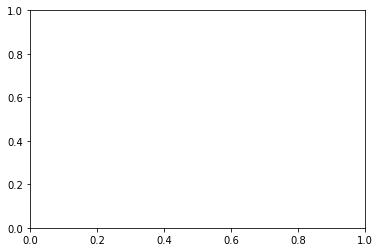

In [9]:
fig, axes = plt.subplots(1, 1)
sampGpL = []
labelL = []
for k, v in sampD.items():
    sampGpL.append(v)
    labelL.append(k)

In [10]:
l = [(float(meanOccD[abbrev])/float(nBedsD[abbrev]), abbrev) for abbrev in abbrevL]
l.sort()
for ratio, abbrev in l[-10:]:
    print '%s %s' % (abbrev, ratio)



THC_6130_L 2.3376344086
SNH_1200_S 2.36444444444
PRES_100_L 3.03255208333
MEMO_527_S 3.36666666667
THC_365_L 3.37304964539
VIBR_9509_L 3.555
THC_2544_L 4.22506265664
RML_5601_L 4.24597701149
KANK_100_S 4.88333333333
THC_4058_L 5.90871794872


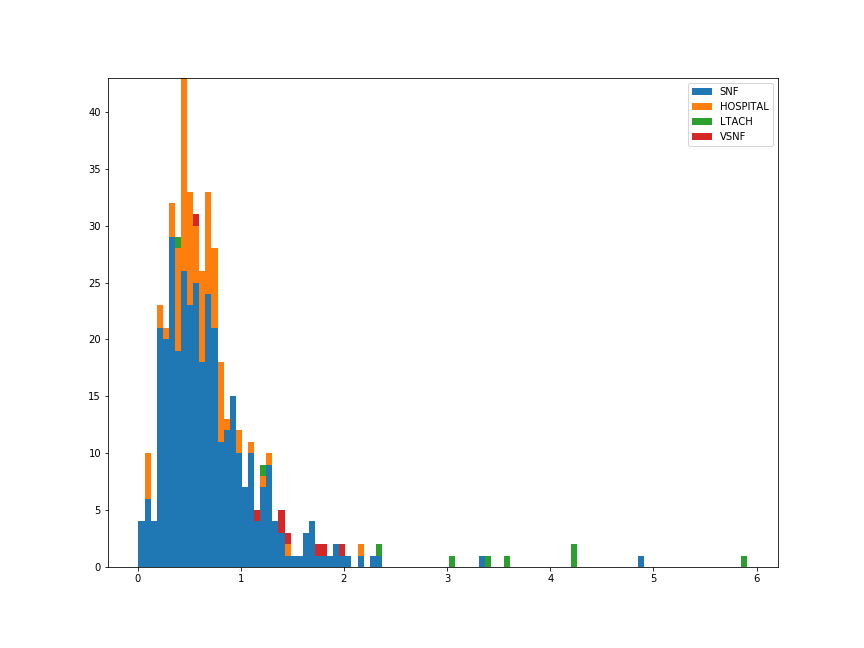

In [11]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [12, 9]
fig, axes = plt.subplots(1,1)
axes.hist(sampGpL, bins=100, stacked=True, label=labelL)
axes.legend()
plt.savefig('test.png')